# EDA and cleaning

In [1]:
%load_ext tensorboard
%tensorboard --logdir=./mylogs;

Reusing TensorBoard on port 6006 (pid 24096), started 3:23:34 ago. (Use '!kill 24096' to kill it.)

In [2]:
import pandas as pd
from tensorflow import keras
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import numpy as np

data_df = pd.read_csv("data/emotions.csv")
data_df.head(20)


,text,label
0,i feel so pissed off over an old friend and so...,anger
1,ive found it has made a huge difference especi...,anger
2,i also feel it is unfortunate that nearly all ...,sadness
3,i feel petty a href http clairee,anger
4,i used to believe that a feeling like fear was...,sadness
5,i sit in the same hostel i did nearly two mont...,sadness
6,i want to just drown myself in the excitement ...,sadness
7,i could easily describe this transformed feeli...,sadness
8,i fought i could feel myself trusting this man...,joy
9,i the ultimate place to restore the peace to f...,joy


In [3]:
# We note that text for links are included and should be removed
import re


def clean_string_in_series(series, patterns):
    # Compile the regex pattern
    regex = re.compile(patterns)

    # Apply the regex substitution to each element of the series
    return series.apply(lambda x: regex.sub("", x) if isinstance(x, str) else x)


# setting pattern and running function
pattern = r"(a href.*|href.*|http.*)"
data_df["text"] = clean_string_in_series(data_df["text"], pattern)

data_df

,text,label
0,i feel so pissed off over an old friend and so...,anger
1,ive found it has made a huge difference especi...,anger
2,i also feel it is unfortunate that nearly all ...,sadness
3,i feel petty,anger
4,i used to believe that a feeling like fear was...,sadness
...,...,...
19995,i was i might be buying stuff from there but i...,joy
19996,i like sonam deepika and genelia who i feel ar...,joy
19997,i feel pathetic that i can hardly go a whole d...,sadness
19998,id have spent more time with her on reading i ...,sadness


In [4]:
# Now that the data is cleaned we do a train, test, val-split

X_train, X_test, y_train, y_test = train_test_split(data_df["text"], data_df["label"], test_size=0.1, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42)

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((15300,), (15300,), (2700,), (2700,), (2000,), (2000,))

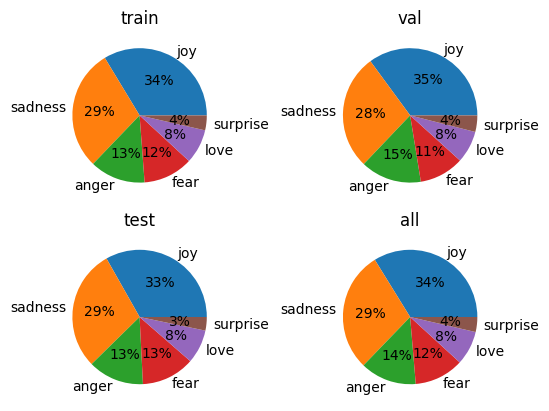

In [5]:
# plotting splits

s_1 = y_train.value_counts()
s_2 = y_val.value_counts()
s_3 = y_test.value_counts()
s_4 = data_df["label"].value_counts()

plt.subplot(2, 2, 1)
plt.title("train")
plt.pie(s_1, labels=s_1.index, autopct='%1.0f%%');

plt.subplot(2, 2, 2)
plt.title("val")
plt.pie(s_2, labels=s_2.index, autopct='%1.0f%%');

plt.subplot(2, 2, 3)
plt.title("test")
plt.pie(s_3, labels=s_3.index, autopct='%1.0f%%');

plt.subplot(2, 2, 4)
plt.title("all")
plt.pie(s_4, labels=s_4.index, autopct='%1.0f%%');

# We note that the data is fairly unbalanced, with joy and sadness being the most common and surprise and love being the least common.
# The balance between the splits is acceptable though

## Vectorization and padding

In [6]:
# integer encoding

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.transform(y_val)
y_test = label_encoder.transform(y_test)

In [38]:
from keras.layers import TextVectorization
from keras.preprocessing.sequence import pad_sequences

VOCAB_SIZE = 1000

# Creating Vectorization instance
encoder = keras.layers.TextVectorization(max_tokens=VOCAB_SIZE, output_mode="int", pad_to_max_tokens=True)
encoder.adapt(X_train)

X_train_vec = encoder(X_train).numpy()
X_val_vec = encoder(X_val).numpy()
X_test_vec = encoder(X_test).numpy()

# padding the X_datasets
MAX_LENGTH = max([len(seq) for seq in X_train_vec])
X_train_padded = pad_sequences(X_train_vec, maxlen=MAX_LENGTH, padding='post')
X_val_padded = pad_sequences(X_val_vec, maxlen=MAX_LENGTH, padding='post')
X_test_padded = pad_sequences(X_test_vec, maxlen=MAX_LENGTH, padding='post')




In [41]:
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN, Dense, GRU, LSTM, Dropout, BatchNormalization
from keras.regularizers import l1_l2

EMBEDDING_DIM = 96  # Size of the word embeddings
RNN_UNITS = 16      # Number of units in RNN layer


model = Sequential([
    # Embedding layer
    Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=MAX_LENGTH),
    
    # RNN layer
    GRU(RNN_UNITS, activation="tanh", return_sequences=False),
    Dropout(0.5),
    
    # Dense layer for classification
    Dense(6, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [42]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 64, 96)            96000     
                                                                 
 gru_7 (GRU)                 (None, 16)                5472      
                                                                 
 dropout_6 (Dropout)         (None, 16)                0         
                                                                 
 dense_7 (Dense)             (None, 6)                 102       
                                                                 
Total params: 101574 (396.77 KB)
Trainable params: 101574 (396.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [43]:
from keras.callbacks import EarlyStopping, TensorBoard
from time import strftime
from pathlib import Path

# Callbacks

# Defining tensorboard callback for logging and visualization
def get_run_logdir(custom_text="", root_logdir="my_logs"):
    formatted_time = strftime("run_%Y_%m_%d_%H_%M_%S")
    if custom_text:
        custom_text = "_" + custom_text
    return Path(root_logdir) / (formatted_time + custom_text)


run_logdir = get_run_logdir("GRU_16units_1layer_dropout_0_5")

tensorboard_cb = TensorBoard(run_logdir)

# Defining earlystopping callback to stop training if model isnt getting better
early_stop_cb = EarlyStopping(monitor="val_loss", patience=10)
run_logdir

WindowsPath('my_logs/run_2024_01_12_14_44_36_GRU_16units_1layer_dropout_0_5_batchnorm')

In [44]:
# Train the model
EPOCHS = 30
BATCH_SIZE = 64

history = model.fit(
    X_train_padded,
    y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val_padded, y_val),
    callbacks=(early_stop_cb, tensorboard_cb)
)

Epoch 1/30
240/240 [==============================] - 9s 26ms/step - loss: 1.6148 - accuracy: 0.3183 - val_loss: 1.5784 - val_accuracy: 0.3507
Epoch 2/30
240/240 [==============================] - 6s 27ms/step - loss: 1.5939 - accuracy: 0.3207 - val_loss: 1.5777 - val_accuracy: 0.3507
Epoch 3/30
240/240 [==============================] - 6s 26ms/step - loss: 1.5887 - accuracy: 0.3250 - val_loss: 1.5759 - val_accuracy: 0.3507
Epoch 4/30
240/240 [==============================] - 6s 26ms/step - loss: 1.5847 - accuracy: 0.3292 - val_loss: 1.5727 - val_accuracy: 0.3507
Epoch 5/30
240/240 [==============================] - 6s 25ms/step - loss: 1.5838 - accuracy: 0.3306 - val_loss: 1.5731 - val_accuracy: 0.3507
Epoch 6/30
240/240 [==============================] - 6s 24ms/step - loss: 1.5820 - accuracy: 0.3305 - val_loss: 1.5722 - val_accuracy: 0.3507
Epoch 7/30
240/240 [==============================] - 6s 25ms/step - loss: 1.1279 - accuracy: 0.5712 - val_loss: 0.4987 - val_accuracy: 0.8311

In [46]:
# evaluate model

model.evaluate(X_test_padded, y_test)

63/63 [==============================] - 0s 7ms/step - loss: 0.5135 - accuracy: 0.8480


[0.5135113596916199, 0.8479999899864197]

## Svar på frågor:

- Motivera din modellarkitektur och val av relevanta hyperparametrar  

Jag testade tre huvudsakliga varianter: SimpleRNN, LSTM och GRU. GRU presterade överlägset bäst och blev snabbt overfittad med upp till 0.95 acc på traindatan trots väldigt enkel arkitektur (1 layer, 8 units). Jag jobbade därför mest med GRU och försökte på olika sätt att bli av med den stora overfittingen. Jag hade ofta 0.95 acc på traindatan och cirka 0.85 acc på val. 

- Vilka aktiveringsfunktioner har du använt? Varför?

tanh i hiddenlayers, softmax i outputlayer. För att det är standard.

- Vilken loss funktion har du använt? Varför?  

sparse_categorical_crossentropy. För att det är standard.

- Har du använt någon databehandling? Motivera dina val.  

Jag tog bort lite text som såg ut att har att göra med länkar till bilder som innehöll "a href"

- Har du använt någon regulariseringsteknik? Motivera.  

Eftersom jag snabbt fick väldigt mycket overfitting även med relativt enkla modeller så har jag jobbat mycket med regularisering, framförallt dropout, som fungerar ganska bra, även ända upp till 0.8. Jag har även provat med Batchnormalization samt L1 och L2, men de har inte gett så bra resultat.

- Hur har modellen utvärderats?  

Jag har använt Tensorboard för att logga mina test, jag har gjort hyperparametertuning manuellt.

- Är prestandan bra? Varför/varför inte?
0.87 acc på val_datan på säger vara bra

- Vad hade du kunnat göra för att förbättra den ytterligare?
Arbeta med dataaugmentation som jag inte har provat. Datasetet är inte jättestort och det hade kunnat vara ett sätt att få ner overfittingen.

- Generativ AI har blivit stort inom text. Beskriv skillnaden mellan generativ AI och mer traditionell AI  

Det beror på vad man menar med tradationell AI. GOFAI använder sig av regler istället för maskininlärning, men mer tradationell maskininlärning använder sig av data för att dra slutsatser om datan på olika sätt. Dels genom att klassificera data till olika klasser, eller att någon form av regression där man försöker beskriva hur någon eller några oberoende variabler förklarar en beroende variabel.

Generativ AI däremot försöker skapa egen data som ska efterlikna den data den tränats på, exempelvis text eller bilder.



## Visualisering

Ursäkta den dåliga kvaliten, bilden ger dock en hint om de många olika varianter av hyperparamterar jag provat som kommer upp i val acc på cirka 0.85

<img src="RNN_tensorboard.png" alt="Alternative text" />